In [10]:
import os
import sys
import h5py
import numpy as np
import torch
# import BART
os.environ['TOOLBOX_PATH'] = "/home/svangurp/scratch/samuel/bart-0.6.00/"
sys.path.append('/home/svangurp/scratch/samuel/bart-0.6.00/python/')
import bart
import fastmri.data.transforms as T
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri import tensor_to_complex_np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [41]:
def pics_func(kspace, slice, crop_size, device, reg_wt, num_iters):
    '''
    This function takes in multi coil kspace data and maskes it and reconstructs it again using PICS form the 
    Bart toolbox. and gives as output the fullly sampled image (target) the linear reconstruction 
    '''
    ## PREPROSESSING 
    print('Pre-prosessing ')
    
    # normalise the im-space that transform back to k-space
    imspace = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace, axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))
    imspace = T.center_crop(imspace, crop_size) 
    imspace = imspace / np.max(np.abs(imspace))

    kspace = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(imspace, axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))
    
    # RSS coil combination for the target image
    target = np.sqrt(np.sum(imspace**2, 1))
    target = target / np.max(np.abs(target))
    
    # creating the mask and masking kaspace
    mask_func = create_mask_for_mask_type(mask_type_str="random", center_fractions=[0.08], accelerations=[4])
    masked_kspace, mask = T.apply_mask(T.to_tensor(kspace), mask_func)
    masked_kspace = torch.view_as_complex(masked_kspace)

    # baseline reconstruction (just leaving the masked data point out)
    linear_recon = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(masked_kspace.detach().cpu().numpy(), 
                                                                 axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))
    linear_recon = np.sqrt(np.sum(linear_recon ** 2, 1))
    linear_recon = linear_recon / np.max(np.abs(linear_recon))
    print('Pre-prosessing  done')
    
    ## estimate the coil sensitivity maps
    print('sens map estimation')
    _masked_kspace = masked_kspace.permute(0, 2, 3, 1).detach().cpu().numpy() # step to get kspace in a form that bart expects 
    sens_maps = bart.bart(1, "ecalib -d0 -m1", _masked_kspace) 
    print('sens map estimation done')
    
    tmp_sens_maps = np.fft.ifft2(np.fft.fftshift(np.fft.fft2(sens_maps[slice], axes=(-3, -2)), axes=(-3, -2)), axes=(-3, -2))
    tmp_imspace = np.fft.ifft2(np.fft.fftshift(_masked_kspace[slice], axes=(-3, -2)), axes=(-3, -2))
    tmp_target = np.sum(tmp_imspace*tmp_sens_maps.conj(), -1)
    
    ## RUNNING BART
    print('Running bart')
    reg_wt = reg_wt
    num_iters = num_iters

    tmp_masked_kspace = np.fft.fftshift(np.expand_dims(_masked_kspace[slice], 0), axes=(-3, -2))

    pred = np.abs(bart.bart(1, f"pics -d0 -S -R T:7:0:{reg_wt} -i {num_iters}", 
                            tmp_masked_kspace, np.expand_dims(sens_maps[slice], 0)))
    pred = np.abs(pred[0])
    
    print('Running bart done')
    
    
    return target[slice], linear_recon[slice], pred

In [42]:
fname = '/scratch/svangurp/samuel/data/knee/train/file1000002.h5'
data = h5py.File(fname, 'r')
kspace = data["kspace"][()]
slice = 20

In [43]:
target, lin_recon, pred = pics_func(kspace, slice = 20, crop_size = (320,320), device ='cuda', reg_wt = 0.01, num_iters = 20)

Preprosessing 
Preprosessing  done
sens map estimation
sens map estimation done
Running bart
Running bart done


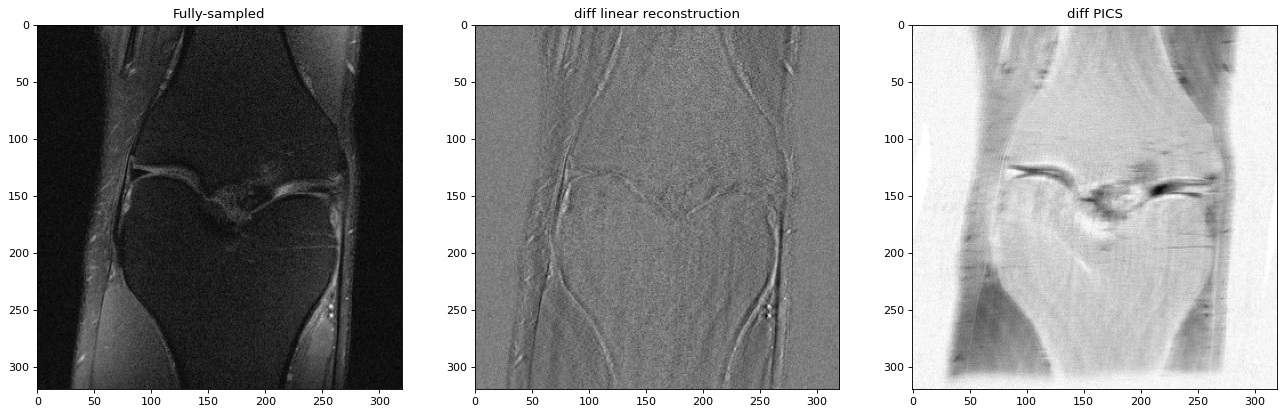

In [40]:
plt.figure(figsize=(20,18), dpi = 80)
plt.subplot(1, 3, 1)
plt.imshow(np.abs(target[slice]), cmap='gray')
plt.title('Fully-sampled')
plt.subplot(1, 3, 2)
plt.imshow(np.abs(target[slice])-np.abs(lin_recon[slice]), cmap='gray')
plt.title('diff linear reconstruction')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(target[slice])-np.abs(pred), cmap='gray')
plt.title('diff PICS')
plt.show()

In [39]:

# # _target = target
# _target = np.expand_dims(np.abs(target[slice]), -1)
# _target = _target / np.max(np.abs(_target))
# # _pred = pred
# _pred = np.expand_dims(np.abs(pred[slice]), -1)
# _pred = _pred / np.max(np.abs(_pred))

# # _linear_recon = lin_recon
# _linear_recon = np.expand_dims(np.abs(lin_recon[slice]), -1)
# _linear_recon = _linear_recon / np.max(np.abs(_linear_recon))

print(lin_recon.shape[slice], target.shape, pred.shape)



SSIM_pics = structural_similarity(_target[slice], _pred, data_range=np.max(_target), multichannel=True)
SSIM_lin_recon = structural_similarity(_target[slice], _linear_recon[slice], data_range=np.max(_target), multichannel=True)

print('SSIM_pics:',SSIM_pics)
print('SSIM_lin_recon:', SSIM_lin_recon)

(38, 320, 320) (38, 320, 320) (320, 320)
SSIM_pics: 0.29786097516737314
SSIM_lin_recon: 0.519357038195776


In [44]:
for i in range(10):
    prinr(i)

NameError: name 'prinr' is not defined